In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.interpolate import UnivariateSpline
from scipy.stats.mstats import gmean
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import zoom as ndizoom

from scipy.signal import savgol_filter

#from mriqa.phantoms import phantom_mask_2d, find_phantom, TO2
from mriqa.dcmio import fetch_series, num_frames, pix_spacing_yx, slice_thickness, rx_coil_name, series_number
#from mriqa.tools import mean_im, diff_im, snr_im, snr, show_mosaic

from mriqa.reports import _get_rect_roi_coords, _get_colour_cycle

In [35]:
def slice_profile_report(dobj, frame=None, flipped_ud=False, flipped_rl=False, phantom=TO2, plate_angle=None, axis=None):
    '''Takes a DICOM object which is a single slice of phantom TO2 where the plate profiles
       are reasonably central. Plots the image with the profile positions marked on, the raw profile
       and a normalised profile accounting for a multiplicative bias field. The FWHM is reported in mm
       for each profile individually and for their geometric mean.
    '''

    # Get image data an interpolate up for analysis, noting change of pixel size
    # Handle multiframes
    if num_frames(dobj) > 1:
        if frame is None:
            frame = num_frames(dobj) // 2
        image = dobj.pixel_array[frame] & 0xfff
    else:
        image = dobj.pixel_array & 0xfff

    pixel_spacing = pix_spacing_yx(dobj)
    slice_thick = slice_thickness(dobj)
    coil_name = rx_coil_name(dobj)

    if flipped_ud:
        image = np.flipud(image)
    if flipped_rl:
        image = np.fliplr(image)

    if plate_angle is None:
        plate_angle = phantom['FeatureAngles']['Plates']
    # In degrees, normally 11.7 for TO2
    assert 0 < plate_angle < 45

    if axis is None:
        axis = phantom['FeatureAxes']['Plates']
    assert axis in (0, 1)

    interpolation_factor = 1 # 2
    if interpolation_factor != 1:
        image = rescale_intensity(ndizoom(image, interpolation_factor))
        pix_dims = np.asarray(pixel_spacing) / interpolation_factor
    else:
        image = rescale_intensity(image)
        pix_dims = np.asarray(pixel_spacing)

    assert np.allclose(pix_dims[0], pix_dims[1])

    # Centre phantom
    expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
    centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)
    centre = centre_x, centre_y

    # Positions of plates
    plates = phantom['Features']['Plates']

    # Plotting area
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    fig.subplots_adjust(wspace=0.5)

    # Phantom image
    axes[0].imshow(image, cmap='bone')
    axes[0].axis('off')
    axes[0].axis('image')

    # Thick profile through first inclined plate
    x, y, dx, dy = _get_rect_roi_coords(pix_dims, rect=plates[0], centre=centre)
    profile_1 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)

    # A list of colours from the line colour cycle so we can match these in the image overlays
    # NB: currently has side effect of moving line property iterator on.
    line_colours = _get_colour_cycle(axes[0], nitems=2)

    # Show profiles on phantom
    axes[0].add_artist(plt.Rectangle([x, y], dx, dy, color=line_colours[0], alpha=0.25))

    # Thick profile through second inclined plate
    x, y, dx, dy = _get_rect_roi_coords(pix_dims, rect=plates[1], centre=centre)
    profile_2 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)

    # Show on phantom
    axes[0].add_artist(plt.Rectangle([x, y], dx, dy, color=line_colours[1], alpha=0.25))

    axes[0].set_title(r'Series %d, Image %d' % (series_number(dobj), dobj.InstanceNumber))

    # Plot raw profiles
    axes[1].plot(profile_1, label='1')
    axes[1].plot(profile_2, label='2')
    axes[1].set_xlabel('Pixel Position')
    axes[1].set_ylabel('Image Brightness (Raw)')
    axes[1].set_title('%s Coil (%1.0f mm)' % (coil_name, slice_thick))
    axes[1].legend()
    axes[1].grid(True)

    # try and find approx range of peak to exclude for a baseline fitting
    
    smoothed_1 = savgol_filter(profile_1, window_length=11, polyorder=3)
    smoothed_2 = savgol_filter(profile_2, window_length=11, polyorder=3)

    centre_1 = np.argmin(smoothed_1)
    centre_2 = np.argmin(smoothed_2)
    
    # say 2*width centred on these over which the signal is less than 75% of average of a ends? 
    
    # Invert profile and normalise to quadratic baseline fitted to the ends of the profile
    x = list(range(75)) + list(range(len(profile_1)-75, len(profile_1)))
    baseline_1 = np.poly1d(np.polyfit(x, profile_1[x], 2))(list(range(len(profile_1))))
    profile_1 /= baseline_1

    x = list(range(75)) + list(range(len(profile_2)-75, len(profile_2)))
    baseline_2 = np.poly1d(np.polyfit(x, profile_2[x], 2))(list(range(len(profile_2))))
    profile_2 /= baseline_2

    profile_1 = 1 - profile_1
    profile_2 = 1 - profile_2

    # Plot the normalised profile
    axes[2].plot(profile_1, label='1')
    axes[2].plot(profile_2, label='2')
    axes[2].set_xlabel('Pixel Position')
    axes[2].set_ylabel('Image Brightness (Normalised to Baseline)')
    axes[2].set_title('%s Coil (%1.0f mm)' % (coil_name, slice_thick))
    axes[2].legend()
    axes[2].grid(True)

    # Create a spline of the profile shifted to move its half-height to zero
    spline = UnivariateSpline(list(range(len(profile_1))), profile_1-np.max(profile_1)/2, s=0)
    r1, r2 = spline.roots()  # find the roots
    axes[2].axvspan(r1, r2, facecolor=line_colours[0], alpha=0.25)

    fwhm_1_pixels = (r2-r1)

    spline = UnivariateSpline(list(range(len(profile_2))), profile_2-np.max(profile_2)/2, s=0)
    r1, r2 = spline.roots()
    axes[2].axvspan(r1, r2, facecolor=line_colours[1], alpha=0.25)
    fwhm_2_pixels = (r2-r1)

    plt.show()

    # Calculate FWHM in mm taking account of pixel rescaling and plate projection angle
    xspacing, yspacing = pix_dims

    fwhm_gm_pixels = gmean([fwhm_1_pixels, fwhm_2_pixels])

    fwhm_1_mm = fwhm_1_pixels * yspacing * np.tan(np.radians(plate_angle))
    fwhm_2_mm = fwhm_2_pixels * yspacing * np.tan(np.radians(plate_angle))

    fwhm_gm_mm = gmean([fwhm_1_mm, fwhm_2_mm])

    print('Plate Angle  = ', '%0.1f degrees' % plate_angle)
    print('FWHM     (1) = ', round(fwhm_1_pixels, 1),  'pixels, or', round(fwhm_1_mm, 1),  'mm')
    print('FWHM     (2) = ', round(fwhm_2_pixels, 1),  'pixels, or', round(fwhm_2_mm, 1),  'mm')
    print('FWHM (GMEAN) = ', round(fwhm_gm_pixels, 1), 'pixels, or', round(fwhm_gm_mm, 1), 'mm')

    return pd.DataFrame(
        [(slice_thick, fwhm_1_pixels, fwhm_1_mm, fwhm_2_pixels, fwhm_2_mm, fwhm_gm_pixels, fwhm_gm_mm)],
        columns=['SliceThickness', 'FWHM1Pixels', 'FWHM1MM', 'FWHM2Pixels', 'FWHM2MM', 'FWHMGMeanPixels', 'FWHMGMeanMM']
    ).set_index('SliceThickness')

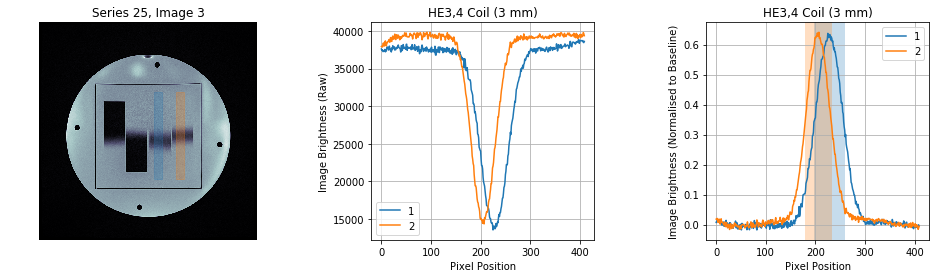

Plate Angle  =  11.7 degrees
FWHM     (1) =  62.5 pixels, or 3.2 mm
FWHM     (2) =  55.3 pixels, or 2.8 mm
FWHM (GMEAN) =  58.8 pixels, or 3.0 mm


In [36]:
# TO2: Slice 3mm
patid = 'PQA20180130RHD'
stuid = '1'

# Distortion Corrected, Phase RL, Uniformity Corrected 1024*1024
dobjs = fetch_series(patid, stuid, sernos=[25])
slice_idx = 2
results = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)